In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

import seaborn as sns

In [2]:
index_data = pd.read_csv('index_data.csv')
north_data = pd.read_csv('north_data.csv')
result_df = pd.read_csv('result_df.csv')

In [3]:
index_data = index_data.set_index('trade_date')
north_data = north_data.set_index('trade_date')

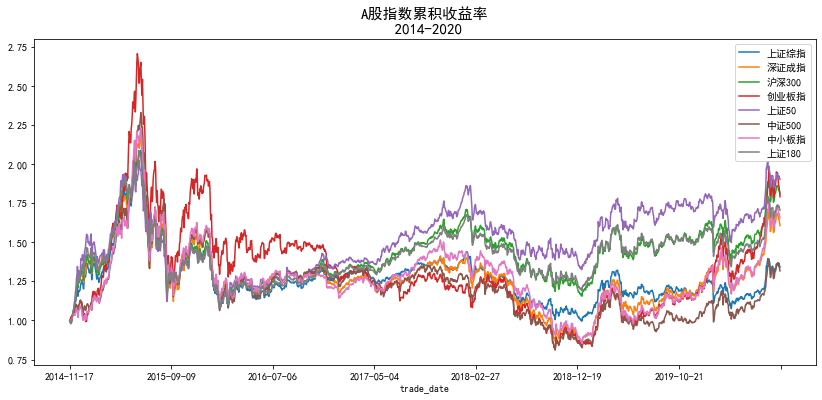

In [4]:
### EDA
(index_data/index_data.iloc[0]).plot(figsize=(14,6))
plt.title("A股指数累积收益率\n 2014-2020", size = 15);

In [5]:
# the correlation of index return and north money in the long term is low
all_ret = index_data/index_data.shift(1) - 1
all_data = all_ret.join(north_data['north_money'], how = 'inner')
all_data.dropna(inplace = True)
all_data.corr()

,上证综指,深证成指,沪深300,创业板指,上证50,中证500,中小板指,上证180,north_money
上证综指,1.000000,0.924464,0.979941,0.765474,0.907355,0.890101,0.865520,0.970900,0.252699
深证成指,0.924464,1.000000,0.916748,0.901830,0.753318,0.962117,0.961679,0.860130,0.290307
沪深300,0.979941,0.916748,1.000000,0.740999,0.942523,0.849081,0.858023,0.989113,0.291449
创业板指,0.765474,0.901830,0.740999,1.000000,0.534840,0.923303,0.937949,0.667121,0.263519
上证50,0.907355,0.753318,0.942523,0.534840,1.000000,0.652926,0.668452,0.974577,0.270995
中证500,0.890101,0.962117,0.849081,0.923303,0.652926,1.000000,0.962797,0.789607,0.235865
中小板指,0.865520,0.961679,0.858023,0.937949,0.668452,0.962797,1.000000,0.789089,0.293066
上证180,0.970900,0.860130,0.989113,0.667121,0.974577,0.789607,0.789089,1.000000,0.272773
north_money,0.252699,0.290307,0.291449,0.263519,0.270995,0.235865,0.293066,0.272773,1.000000


In [6]:
# the correlation is higher in the short term
all_data.rolling(120).corr().tail(9)

上证综指      深证成指     沪深300      创业板指      上证50  \
trade_date                                                                 
2020-08-12 上证综指         1.000000  0.929499  0.987080  0.832694  0.964184   
           深证成指         0.929499  1.000000  0.945616  0.964512  0.843982   
           沪深300        0.987080  0.945616  1.000000  0.854003  0.969139   
           创业板指         0.832694  0.964512  0.854003  1.000000  0.723766   
           上证50         0.964184  0.843982  0.969139  0.723766  1.000000   
           中证500        0.921310  0.980542  0.911526  0.949704  0.808102   
           中小板指         0.893568  0.987329  0.916322  0.958564  0.803494   
           上证180        0.987040  0.891497  0.987366  0.782050  0.991134   
           north_money  0.666148  0.635636  0.700535  0.580554  0.702172   

                           中证500      中小板指     上证180  north_money  
trade_date                                                         
2020-08-12 上证综指         0.921310  0.893568  0.987040     0.666148  
           深证成指         0.980542  0.987329  0.891497     0.635636  
           沪深300        0.911526  0.916322  0.987366     0.700535  
           创业板指         0.949704  0.958564  0.782050     0.580554  
           上证50         0.808102  0.803494  0.991134     0.702172  
           中证500        1.000000  0.965511  0.866490     0.576626  
           中小板指         0.965511  1.000000  0.855046     0.628698  
           上证180        0.866490  0.855046  1.000000     0.690962  
           north_money  0.576626  0.628698  0.690962     1.000000

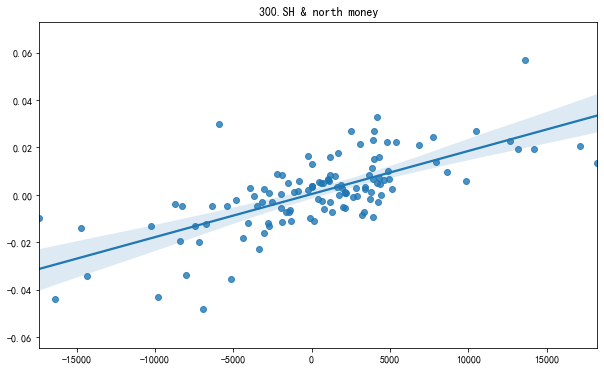

In [7]:
# take 300.SH as an example
plt.figure(figsize=(10,6))
plt.title('300.SH & north money')
sns.regplot(x=list(all_data['north_money'][-120:]), y=list(all_data['沪深300'][-120:]));

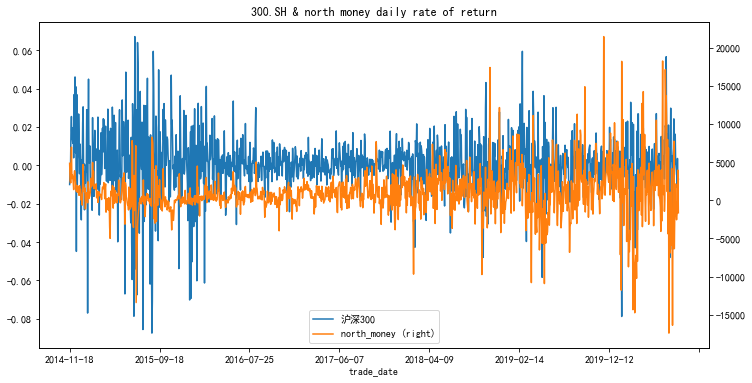

In [8]:
final_data = all_data[['沪深300', 'north_money']].dropna()
final_data.plot(secondary_y = 'north_money', figsize=(12,6))
plt.title('300.SH & north money daily rate of return');

In [9]:
def cal_roling_corr(df, period=30):
    corrs = df.rolling(period).corr()
    corrs = corrs.dropna().iloc[1::2,0]
    corrs = corrs.reset_index()
    corrs = corrs.set_index('trade_date')
    
    return corrs['沪深300']

In [10]:
corr = cal_roling_corr(final_data, period = 120)
corr.describe()

count    1236.000000
mean        0.334559
std         0.219806
min        -0.215172
25%         0.219457
50%         0.379527
75%         0.525442
max         0.705992
Name: 沪深300, dtype: float64

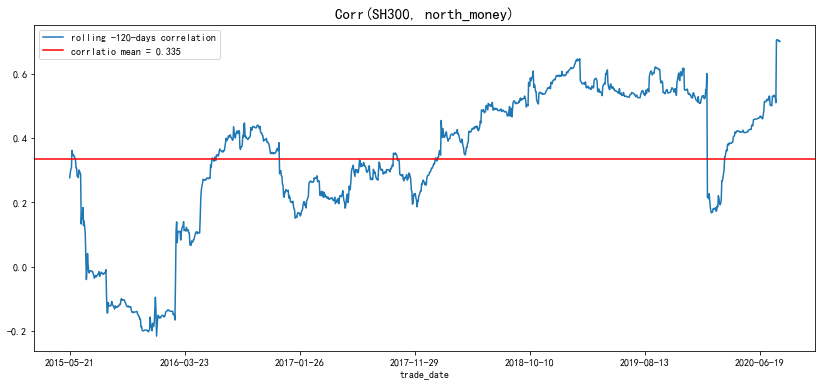

In [11]:
# positive correlation
corr.plot(figsize=(14,6), label='rolling -120-days correlation')
plt.title('Corr(SH300, north_money)', size = 15)
plt.axhline(corr.mean(), c='r', label='corrlatio mean = 0.335')
plt.legend(loc=2);

In [12]:
def North_strategy(df, window, std_n, cost):
    '''
    df: north money and index data;
    window: rolling window size;
    std_n: n times standard deviation;
    cost: cost
    '''
    df = df.copy().dropna()
    df['mid'] = df['north_money'].rolling(window).mean()
    std = df['north_money'].rolling(window).std()
    
    df['upper'] = df['mid'] + std_n * std
    df['lower'] = df['mid'] - std_n * std
    df['rtn'] = df.close/df.close.shift(1) - 1
    df = df.dropna()
    
    #generate signal
    df.loc[df['north_money'] > df.upper, 'signal'] = 1
    df.loc[df['north_money'] < df.lower, 'signal'] = 0
    df['position'] = df['signal'].shift(1)
    df['position'].fillna(method='ffill', inplace=True)
    df.position.fillna(0, inplace = True)
    
    #calculate the rate of return
    df.loc[df.index[0], 'capital_rtn'] = 0
    df.loc[df['position'] > df['position'].shift(1), 'capital_rtn'] = (df.close / df.open - 1) * (1 - cost)
    df.loc[df['position'] == df['position'].shift(1), 'capital_rtn'] = df['rtn'] * df['position']
    df['strategy_y'] = (df.capital_rtn + 1.0).cumprod()
    df['index_y'] = (df.rtn + 1.0).cumprod()
    
    return df

In [19]:
result_df = result_df.rename(columns = {'北向资金':'north_money'})
result = North_strategy(result_df,120,1.5,0)
result = result.set_index('trade_date')

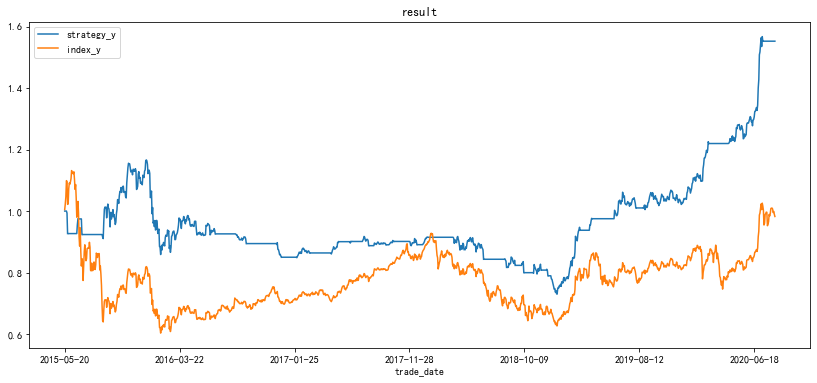

In [22]:
result[['strategy_y', 'index_y']].plot(figsize=(14,6))
plt.title('result');